# Projet SD701 -  Analyse des données

In [1]:
import math as m
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import cluster, linear_model
from sklearn.decomposition import PCA
from pandas.plotting import scatter_matrix

import pandas as pd
import numpy as np
import requests

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.axis as axis
import seaborn as sns

from xml.dom import minidom
from lxml import etree
from bs4 import BeautifulSoup
import io
from os import listdir
import random
import json

import datetime
import time
from meteostat import Point, Daily, Hourly
from operator import itemgetter


# Ouverture des df

## df_dep

In [2]:
# fonction pour mettre tous les codes départements en str
def chang_str(x):
    try:
        return str(int(x))
    except:
        return str(x)


In [3]:
# import des départements
with open('depreg.geojson') as fic_depreg:
    depreg = json.load(fic_depreg)
df_dep = pd.DataFrame({'num': [i['properties']['code']for i in depreg['features']],
                      'poly_dep': [i['geometry']['coordinates'] for i in depreg['features']]})
df_dep['num'] = df_dep['num'].apply(chang_str)
df_dep.head()


num                                           poly_dep
0   2  [[[3.172704445659, 50.011996744997], [3.182197...
1  10  [[[3.4147888224632, 48.390268550005], [3.42207...
2  14  [[[-1.1196198636379, 49.355568981262], [-1.115...
3  15  [[[2.5084125130653, 45.478501516921], [2.52443...
4  28  [[[0.8148247207739, 48.670163564137], [0.82767...

In [4]:
# récupération des polygones
def ret_lis(l, w):
    if type(l[0][0]) != float:
        for i in l:
            ret_lis(i, w)
    else:
        w.append(l)
    return w

# fonction permettant d'afficher sur carte les départements


def dep(lis_dep):
    compteur = 0
    for i in df_dep.loc[df_dep['num'].isin(lis_dep), 'poly_dep']:
        w = []
        polys = ret_lis(i, w)
        #pt_moy = [0,0]
        for poly in polys:
            x, y = [j[0] for j in poly], [j[1] for j in poly]
            plt.plot(x, y, c='k', alpha=0.3)
            #pt_moy[0] = pt_moy[0] + sum(x)/len(x)/len(polys)
            #pt_moy[1] = pt_moy[1] + sum(y)/len(y)/len(polys)
        #plt.text(pt_moy[0], pt_moy[1], df_dep['num'][compteur], size = 6)
        compteur += 1


In [5]:
IDF = ['75', '91', '92', '93', '94', '95', '78', '77']
dep(IDF)


## df_sites

In [5]:
# df_sites
fic = 'dataset/' + "_".join(sorted([f.split("_") for f in listdir('dataset') if f.split("_")[1] == 'sites'],
                                   key=itemgetter(2, 3))[-1])
print('ouverture de %s\n' % fic)
df_sites = pd.read_csv(fic, index_col=None, low_memory=False)
df_sites.head()


ouverture de dataset/df_sites_20211125_091353.csv



code site           nom site        lat      long    alt  Altitude Moyenne  \
0   FR01001  Longlaville-Ecole  49.535004  5.804447  265.0             294.0   
1   FR01004           Distroff  49.332497  6.271664  223.0             204.0   
2   FR01005            Hayange  49.324722  6.076108  187.0             253.0   
3   FR01006           Florange  49.320830  6.140000  158.0             177.0   
4   FR01009          Gandrange  49.271393  6.132500  180.0             180.0   

  Code INSEE Code Postal      Commune         Département  ...  \
0      54321       54810  LONGLAVILLE  MEURTHE-ET-MOSELLE  ...   
1      57179       57925     DISTROFF             MOSELLE  ...   
2      57306       57700      HAYANGE             MOSELLE  ...   
3      57221       57190     FLORANGE             MOSELLE  ...   
4      57242       57175    GANDRANGE             MOSELLE  ...   

             Statut Superficie  Population  \
0    Commune simple      313.0         2.5   
1    Commune simple      798.0         1.6   
2  Chef-lieu canton     1223.0        15.5   
3  Chef-lieu canton     1318.0        11.2   
4    Commune simple      411.0         2.9   

                                           geo_shape  \
0  {"type": "Polygon", "coordinates": [[[5.804438...   
1  {"type": "Polygon", "coordinates": [[[6.250460...   
2  {"type": "Polygon", "coordinates": [[[6.094813...   
3  {"type": "Polygon", "coordinates": [[[6.132507...   
4  {"type": "Polygon", "coordinates": [[[6.153646...   

                                            poly_dep Code Commune  \
0  [[[[5.4555586843759, 49.480931549678], [5.4495...          321   
1  [[[7.6352815933424, 49.054164206261], [7.63470...          179   
2  [[[7.6352815933424, 49.054164206261], [7.63470...          306   
3  [[[7.6352815933424, 49.054164206261], [7.63470...          221   
4  [[[7.6352815933424, 49.054164206261], [7.63470...          242   

   Code Canton  Code Arrondissement  Code Département Code Région  
0           30                    1                54          41  
1           21                    7                57          41  
2           15                    8                57          41  
3           39                    8                57          41  
4           22                    8                57          41  

[5 rows x 21 columns]

## df_tot

In [6]:
# ouverture du dernier df_tot

fic = 'dataset/' + "_".join(sorted([f.split("_") for f in listdir('dataset') if f.split("_")[1] == 'tot'],
                                   key=itemgetter(2, 3))[-1])
print('ouverture de %s\n' % fic)
df_tot = pd.read_csv(fic)
df_tot.drop(df_tot.columns[0], axis=1, inplace=True)
df_tot['GDH'] = pd.to_datetime(df_tot['GDH'])
df_tot['Code Département'] = df_tot['Code Département'].apply(chang_str)
df_tot.drop(df_tot.loc[df_tot['tavg'].isnull()].index, axis=0, inplace=True)
df_tot.drop(['snow', 'wdir', 'wspd', 'wpgt', 'tsun'], axis=1, inplace=True)
df_tot.head()


ouverture de dataset/df_tot_20211125_210212.csv



GDH code site  PicJourConsoNat  type_poll  verif  valid     mesure  \
0 2018-09-17   FR02011          53588.0          1      3      1   0.183333   
1 2018-09-20   FR02011          54243.0          1      3      1   1.050000   
2 2018-09-22   FR02011          47614.0          1      3      1   3.530000   
3 2018-09-24   FR02011          53454.0          1      2      1  19.148053   
4 2018-09-27   FR02011          54560.0          1      3      1   1.283689   

   mesure_max  mesure_min       lat  ...   alt  Population  Code Département  \
0    0.500000        0.00  43.43786  ...  21.0        15.5                13   
1    2.000000        0.50  43.43786  ...  21.0        15.5                13   
2   29.800000       -0.30  43.43786  ...  21.0        15.5                13   
3  105.650000        0.25  43.43786  ...  21.0        15.5                13   
4    3.428571        0.00  43.43786  ...  21.0        15.5                13   

   tavg  tmin  tmax  prcp    pres        Jx        Jy  
0  21.2  15.9  25.9   0.0  1019.8  1.000000  0.000000  
1  22.4  15.9  29.9   0.0  1017.5 -0.900969  0.433884  
2  20.8  15.9  27.9   0.0  1019.0 -0.222521 -0.974928  
3  18.5  15.9  23.9   0.0  1019.4  1.000000  0.000000  
4  16.7  11.4  23.5   0.0  1028.9 -0.900969  0.433884  

[5 rows x 21 columns]

In [7]:
# on prend le parti de supprimer toute ligne possédant un NaN
df_tot.drop(df_tot[df_tot.isna().any(axis=1)].index, axis=0, inplace=True)


In [10]:
df_tot


GDH code site  PicJourConsoNat  type_poll  verif  valid  \
0       2018-09-17   FR02011          53588.0          1      3      1   
1       2018-09-20   FR02011          54243.0          1      3      1   
2       2018-09-22   FR02011          47614.0          1      3      1   
3       2018-09-24   FR02011          53454.0          1      2      1   
4       2018-09-27   FR02011          54560.0          1      3      1   
...            ...       ...              ...        ...    ...    ...   
2222651 2021-03-02   FR03071          67536.0          8      2      1   
2222652 2021-03-03   FR03071          65661.0          8      2      1   
2222653 2021-03-03   FR03071          65661.0          8      3      1   
2222654 2021-03-06   FR03071          63233.0          8      3      1   
2222655 2021-03-07   FR03071          63153.0          8      3      1   

            mesure  mesure_max  mesure_min       lat  ...   alt  Population  \
0         0.183333    0.500000    0.000000  43.43786  ...  21.0        15.5   
1         1.050000    2.000000    0.500000  43.43786  ...  21.0        15.5   
2         3.530000   29.800000   -0.300000  43.43786  ...  21.0        15.5   
3        19.148053  105.650000    0.250000  43.43786  ...  21.0        15.5   
4         1.283689    3.428571    0.000000  43.43786  ...  21.0        15.5   
...            ...         ...         ...       ...  ...   ...         ...   
2222651  36.770833   72.600000   16.800000  43.13111  ...  26.0       165.5   
2222652  23.041748   72.600000    3.500000  43.13111  ...  26.0       165.5   
2222653  42.903459   72.910000   17.500000  43.13111  ...  26.0       165.5   
2222654  16.701811   42.058333    7.800000  43.13111  ...  26.0       165.5   
2222655   9.440675   18.761538    6.138462  43.13111  ...  26.0       165.5   

         Code Département  tavg  tmin  tmax  prcp    pres        Jx        Jy  
0                      13  21.2  15.9  25.9   0.0  1019.8  1.000000  0.000000  
1                      13  22.4  15.9  29.9   0.0  1017.5 -0.900969  0.433884  
2                      13  20.8  15.9  27.9   0.0  1019.0 -0.222521 -0.974928  
3                      13  18.5  15.9  23.9   0.0  1019.4  1.000000  0.000000  
4                      13  16.7  11.4  23.5   0.0  1028.9 -0.900969  0.433884  
...                   ...   ...   ...   ...   ...     ...       ...       ...  
2222651                83  11.7   9.8  14.2   0.0  1031.3  0.623490  0.781831  
2222652                83  10.7   8.4  13.6   0.0  1031.2 -0.222521  0.974928  
2222653                83  10.7   8.4  13.6   0.0  1031.2 -0.222521  0.974928  
2222654                83  11.1   9.4  13.6   0.6  1022.8 -0.222521 -0.974928  
2222655                83  10.6   8.5  12.6   0.0  1021.9  0.623490 -0.781831  

[1673207 rows x 21 columns]

In [8]:
# standardisation des métriques utilisées, on groupe par type de polluant

poll = set(df_tot['type_poll'])
dataset = []
for i in poll:
    part = df_tot.groupby('type_poll').get_group(i)
    for j in ['mesure', 'mesure_max', 'mesure_min']:
        a = (part[j] - part[j].mean())/part[j].std()
        part[j] = a
    dataset.append(part)
df_tot = pd.concat(dataset)
df_tot.reset_index(inplace=True)
df_tot.drop(df_tot.columns[0], axis=1, inplace=True)
df_tot.head()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


GDH code site  PicJourConsoNat  type_poll  verif  valid    mesure  \
0 2018-09-17   FR02011          53588.0          1      3      1 -0.389358   
1 2018-09-20   FR02011          54243.0          1      3      1 -0.188957   
2 2018-09-22   FR02011          47614.0          1      3      1  0.384498   
3 2018-09-24   FR02011          53454.0          1      2      1  3.995891   
4 2018-09-27   FR02011          54560.0          1      3      1 -0.134920   

   mesure_max  mesure_min       lat  ...   alt  Population  Code Département  \
0   -0.325113   -0.164764  43.43786  ...  21.0        15.5                13   
1   -0.254782    0.064495  43.43786  ...  21.0        15.5                13   
2    1.048686   -0.302320  43.43786  ...  21.0        15.5                13   
3    4.605091   -0.050134  43.43786  ...  21.0        15.5                13   
4   -0.187801   -0.164764  43.43786  ...  21.0        15.5                13   

   tavg  tmin  tmax  prcp    pres        Jx        Jy  
0  21.2  15.9  25.9   0.0  1019.8  1.000000  0.000000  
1  22.4  15.9  29.9   0.0  1017.5 -0.900969  0.433884  
2  20.8  15.9  27.9   0.0  1019.0 -0.222521 -0.974928  
3  18.5  15.9  23.9   0.0  1019.4  1.000000  0.000000  
4  16.7  11.4  23.5   0.0  1028.9 -0.900969  0.433884  

[5 rows x 21 columns]

In [9]:
df_tot.columns


Index(['GDH', 'code site', 'PicJourConsoNat', 'type_poll', 'verif', 'valid',
       'mesure', 'mesure_max', 'mesure_min', 'lat', 'long', 'alt',
       'Population', 'Code Département', 'tavg', 'tmin', 'tmax', 'prcp',
       'pres', 'Jx', 'Jy'],
      dtype='object')

# Visualisation

In [10]:
# fonction d'affichage des moyennes des mesures sur une période donnée et dans des départements donnés
def graph_poll(date_start, date_end, lis_dep, lab=False, graph=False):
    a = df_tot.loc[df_tot['Code Département'].isin(lis_dep)]
    a = a.set_index('GDH').loc[date_start:date_end].groupby(['code site']).agg({'mesure': 'mean',
                                                                                'Code Département': 'first',
                                                                                'lat': 'first',
                                                                                'long': 'first'})
    if graph == True:
        plt.figure(figsize=(15, 10))
    dep(lis_dep)
    var = plt.scatter(a['long'], a['lat'], c=a['mesure']*10, cmap=plt.cm.Spectral_r,
                      edgecolors='none', s=200, alpha=0.7)
    plt.xlabel('longitude', size=15)
    plt.ylabel('lattitude', size=15)
    plt.colorbar(var, label='pollution')
    if date_start == date_end:
        plt.title(f'Pollution en {date_end}', size=20)
    else:
        plt.title(f'Pollution du {date_start} au {date_end}', size=20)
    if lab == True:
        a = pd.merge(a, df_sites[['code site', 'Commune']],
                     left_on='code site', right_on='code site', how='left')
        for x, y, text in zip(a['long'], a['lat'], a['Commune']):
            plt.annotate(text, (x, y))
    if graph == True:
        plt.show()


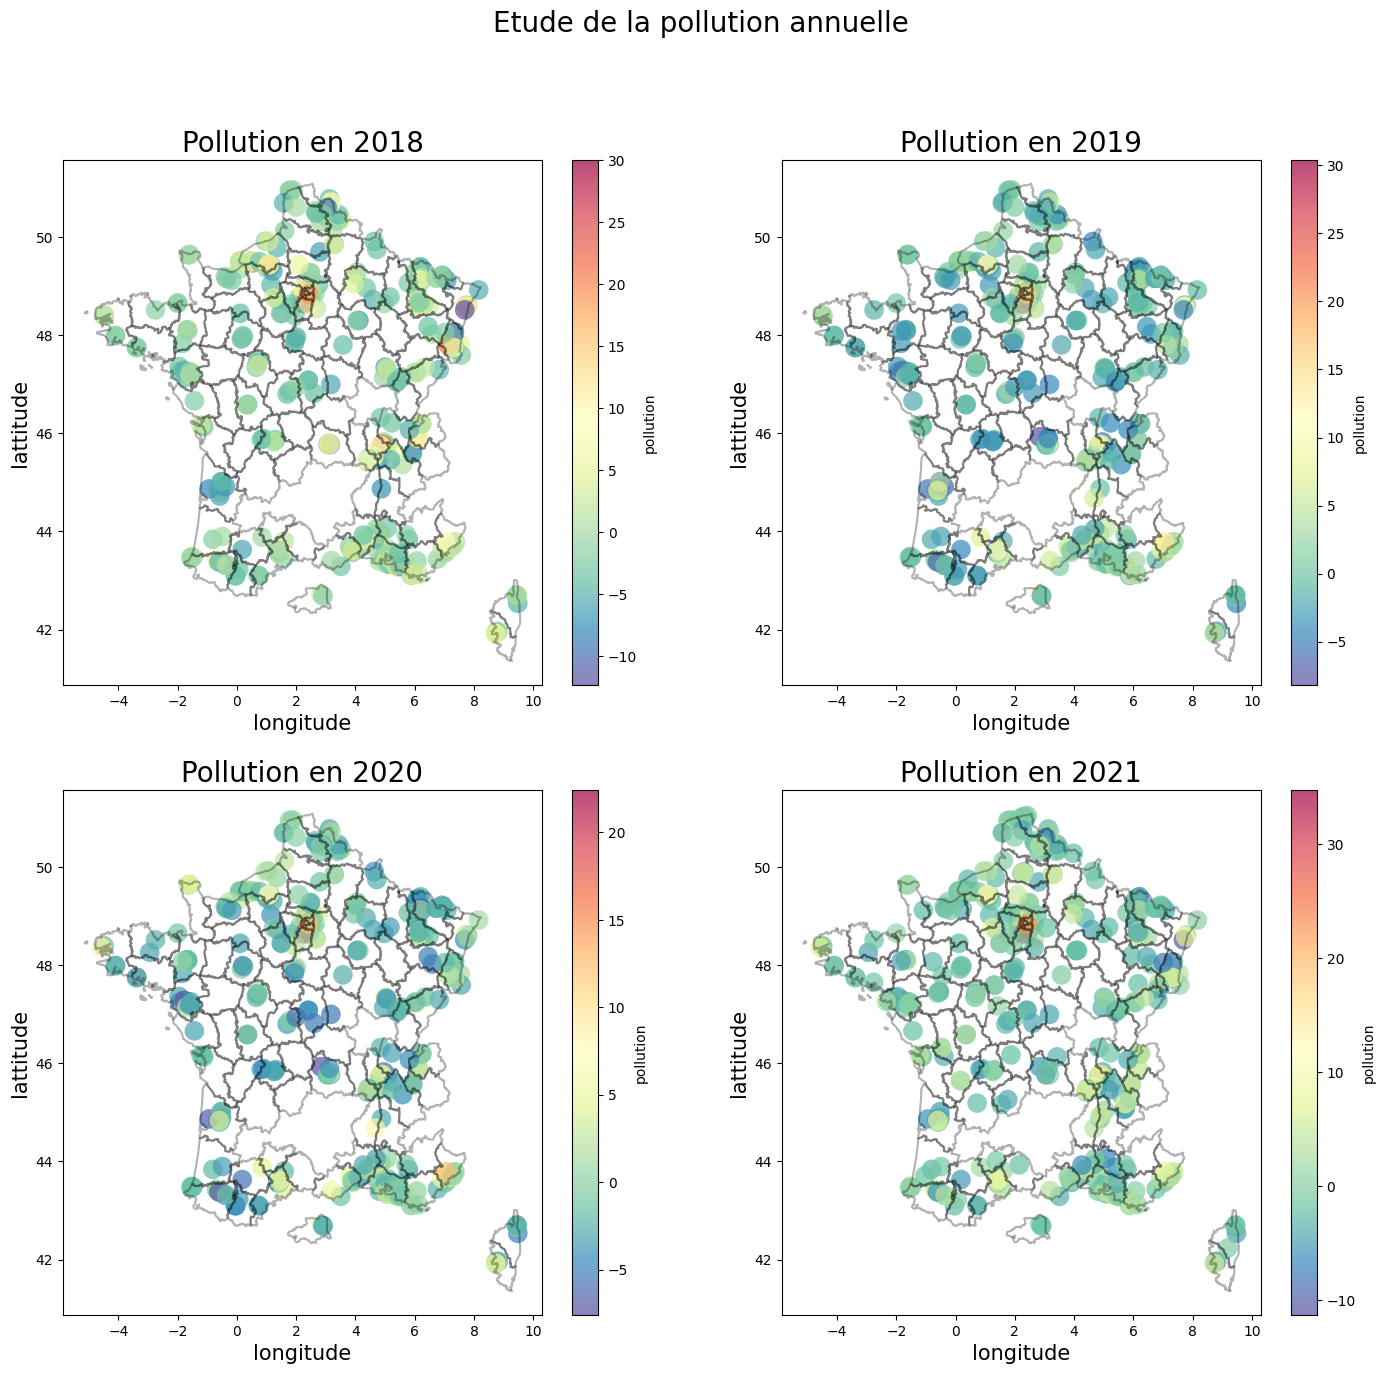

In [11]:
plt.figure(figsize=(17, 15))
plt.suptitle('Etude de la pollution annuelle', size=20)
for i in range(4):
    plt.subplot(2, 2, i+1)
    graph_poll(str(2018+i), str(2018+i), set(df_tot['Code Département']))
plt.show()


In [12]:
graph_poll('2019', '2019', IDF, lab=False, graph=True)


NameError: name 'IDF' is not defined

In [19]:
df_sites


code site             nom site        lat      long    alt
0     FR01001    Longlaville-Ecole  49.535004  5.804447  265.0
1     FR01004             Distroff  49.332497  6.271664  223.0
2     FR01005              Hayange  49.324722  6.076108  187.0
3     FR01006             Florange  49.320830  6.140000  158.0
4     FR01009            Gandrange  49.271393  6.132500  180.0
..        ...                  ...        ...       ...    ...
828   FR82200  Besancon pl Leclerc  47.242500  6.015200  281.0
829   FR82210   Bouclans (Nancray)  47.245800  6.183600  335.0
830   FR82220       Sochaux Mairie  47.513100  6.831800  321.0
831   FR82512  Besancon rue Vesoul  47.253292  6.016094  309.0
832   FR82514   Besancon Madeleine  47.240993  6.018156  255.0

[833 rows x 5 columns]

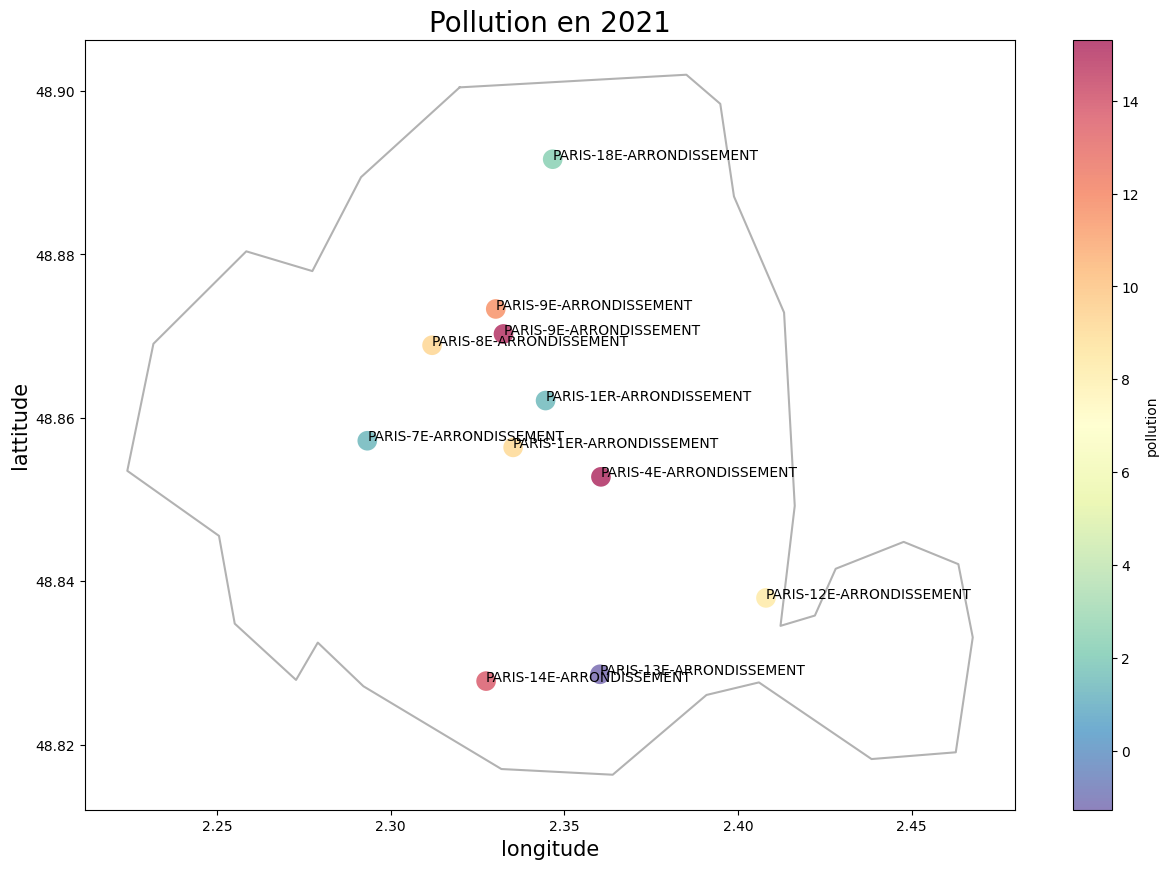

In [13]:
graph_poll('2021', '2021', ['75'], lab=True, graph=True)


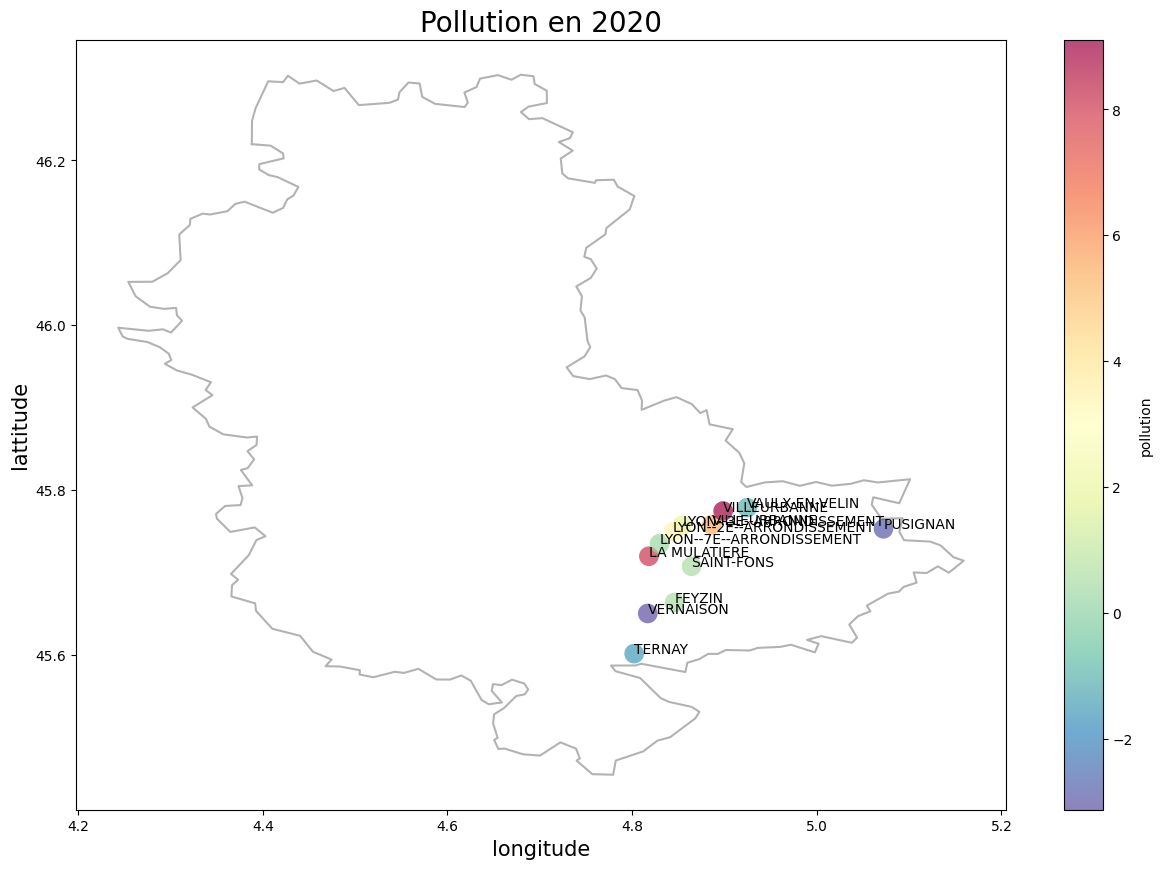

In [14]:
graph_poll('2020', '2020', ['69'], lab=True, graph=True)


# KMeans

In [15]:
df_tot.columns


Index(['GDH', 'code site', 'PicJourConsoNat', 'type_poll', 'verif', 'valid',
       'mesure', 'mesure_max', 'mesure_min', 'lat', 'long', 'alt',
       'Population', 'Code Département', 'tavg', 'tmin', 'tmax', 'prcp',
       'pres', 'Jx', 'Jy'],
      dtype='object')

In [13]:
# standardisation des métriques utilisées, on groupe par type de polluant
df_tot_std = df_tot.copy()
for i in ['mesure', 'mesure_max', 'mesure_min', 'alt', 'tavg', 'tmin', 'tmax',
          'prcp', 'prcp', 'pres', 'PicJourConsoNat', 'Population',
          'Jx', 'Jy']:
    a = StandardScaler().fit_transform(np.array(df_tot_std[i]).reshape(-1, 1))
    df_tot_std[i] = a

# standardisation des coordonnées: on garde aussi les vraies coordonnées pour les mapper
df_tot_std['lat_cr'] = StandardScaler().fit_transform(
    np.array(df_tot['lat']).reshape(-1, 1))
df_tot_std['long_cr'] = StandardScaler().fit_transform(
    np.array(df_tot['lat']).reshape(-1, 1))

# nettoyage des données:
# df_tot = df_tot#.fillna(method='bfill')
#df_tot = df_tot.loc[df_tot['mean']<10]

df_tot_std.head()


GDH code site  PicJourConsoNat  type_poll  verif  valid    mesure  \
0 2018-09-17   FR02011        -0.655893          1      3      1 -0.389359   
1 2018-09-20   FR02011        -0.596931          1      3      1 -0.188957   
2 2018-09-22   FR02011        -1.193669          1      3      1  0.384499   
3 2018-09-24   FR02011        -0.667956          1      2      1  3.995902   
4 2018-09-27   FR02011        -0.568394          1      3      1 -0.134921   

   mesure_max  mesure_min       lat  ...  Code Département      tavg  \
0   -0.325114   -0.164764  43.43786  ...                13  1.383310   
1   -0.254783    0.064495  43.43786  ...                13  1.566551   
2    1.048689   -0.302320  43.43786  ...                13  1.322229   
3    4.605104   -0.050135  43.43786  ...                13  0.971017   
4   -0.187801   -0.164764  43.43786  ...                13  0.696154   

       tmin      tmax      prcp      pres        Jx        Jy    lat_cr  \
0  1.362245  1.166672 -0.406339  0.336256  1.442905 -0.068504 -1.426586   
1  1.362245  1.679044 -0.406339  0.082719 -1.228119  0.551041 -1.426586   
2  1.362245  1.422858 -0.406339  0.248070 -0.274842 -1.460610 -1.426586   
3  1.362245  0.910486 -0.406339  0.292163  1.442905 -0.068504 -1.426586   
4  0.602121  0.859249 -0.406339  1.339382 -1.228119  0.551041 -1.426586   

    long_cr  
0 -1.426586  
1 -1.426586  
2 -1.426586  
3 -1.426586  
4 -1.426586  

[5 rows x 23 columns]

On regroupe les polluants en prenant la moyenne de pollution par jour et par site 

In [14]:
# df_mean: df de moyenne de la pollution sur les trois ans par site
df_mean = df_tot_std.groupby(['code site', 'Code Département']).agg({
    'PicJourConsoNat': 'mean',
    'Population': 'mean',
    'alt': 'mean',
    'lat': 'first',
    'lat_cr': 'first',
    'long': 'first',
    'long_cr': 'first',
    'prcp': 'mean',
    'pres': 'mean',
    # 'snow':'mean',
    'tavg': 'mean',
    'tmax': 'mean',
    'tmin': 'mean',
    # 'tsun':'mean',
    # 'wdir':'mean',
    # 'wpgt':'mean',
    # 'wspd':'mean',
    'mesure': 'mean'}).reset_index().fillna(method='bfill')


In [18]:
df_mean.head()


code site Code Département  PicJourConsoNat  Population       alt  \
0   FR01005               57         0.062918   -0.501913  0.364156   
1   FR01011               57         0.045396    0.888754  0.398789   
2   FR01012               57         0.036062    0.888754  0.481909   
3   FR01014               54         0.060642   -0.514996  0.308743   
4   FR01015               54         0.177880   -0.647129  0.357229   

         lat    lat_cr      long   long_cr      prcp      pres      tavg  \
0  49.324722  0.994628  6.076108  0.994628  0.021970 -0.163138 -0.289019   
1  49.119442  0.910198  6.180833  0.910198 -0.044542  0.031495 -0.237107   
2  49.110283  0.906431  6.223336  0.906431 -0.059139  0.076050 -0.201390   
3  48.915000  0.826113  6.058336  0.826113 -0.026533  0.018869 -0.229589   
4  48.884724  0.813661  6.051392  0.813661 -0.061926  0.008460 -0.270021   

       tmax      tmin    mesure  
0 -0.410098 -0.106221 -0.313073  
1 -0.274352 -0.190090 -0.113913  
2 -0.231197 -0.168031 -0.243293  
3 -0.286459 -0.166650 -0.080068  
4 -0.307556 -0.208742  0.093313

On teste tout d'abord le KMeans sur toutes les métriques numériques


In [15]:
# clustering par k-means:
def km(df, nb_clust):
    dfk = df.fillna(0)
    # .loc[df_mean['GDH'].dt.]
    #dfk = dfk.loc[dfk['mean']<10]
    cols = ['mesure', 'Population',
            # 'alt',
            #'lat_cr', 'long_cr',
            # 'PicJourConsoNat',
            #'lat', 'long',
            'tavg',  'pres', 'prcp',
            ]

    kmeans_algo = cluster.KMeans(n_clusters=nb_clust)
    kmeans_algo.fit(dfk[cols])
    dfk['cluster'] = kmeans_algo.labels_

    return dfk


def graph_km(dfk, label_col):
    labels = dfk[label_col].unique()
    nb_clust = len(labels)
    colormap = np.array(["#"+''.join([random.choice('ABCDEF0123456789')
                        for i in range(6)]) for _ in range(nb_clust)])
    # création d'une liste comportant tous les binômes de paramètres étudiés
    L = ['alt',  'tavg', 'pres', 'prcp', 'lat', 'Population']

    # représentation des six nuages de points pour identifier visuellement le(s) binôme(s) le(s) plus pertinent:

    plt.figure(figsize=(15, 10))
    for i in range(len(L)):
        plt.subplot(2, 3, i+1)
        plt.scatter(dfk[L[i]], dfk['mesure'],
                    c=colormap[dfk[label_col]], alpha=0.5, s=10)
        plt.title('Pollution'+' / '+dfk[L[i]].name)
    plt.subplot(2, 3, 6)
    plt.show()

    # Affichage sur la carte
    plt.figure(figsize=(12, 12))

    # on rajoute le dept 11 qui n'a pas de station de mesure si le Df prend en compte toute la France
    if set(dfk['Code Département']) == set(df_tot['Code Département']):
        dep(list(set(dfk['Code Département']))+['11'])
    else:
        dep(set(dfk['Code Département']))

    for i in set(labels):
        plt.scatter(dfk.loc[dfk[label_col] == i, 'long'],
                    dfk.loc[dfk[label_col] == i, 'lat'],
                    s=200, alpha=0.5,
                    c=colormap[i],
                    label=f'clust {str(i+1)}')
    plt.title(f'K-means à {len(labels)} clusters', size=20)
    plt.xlabel('longitude')
    plt.ylabel('lattitude')
    plt.legend()
    plt.show()

    pair_cols = ['mesure', 'Population', 'tavg',  'pres', 'prcp', 'labels']
    #sns.pairplot(dfk[pair_cols], hue="labels")
    # plt.show()


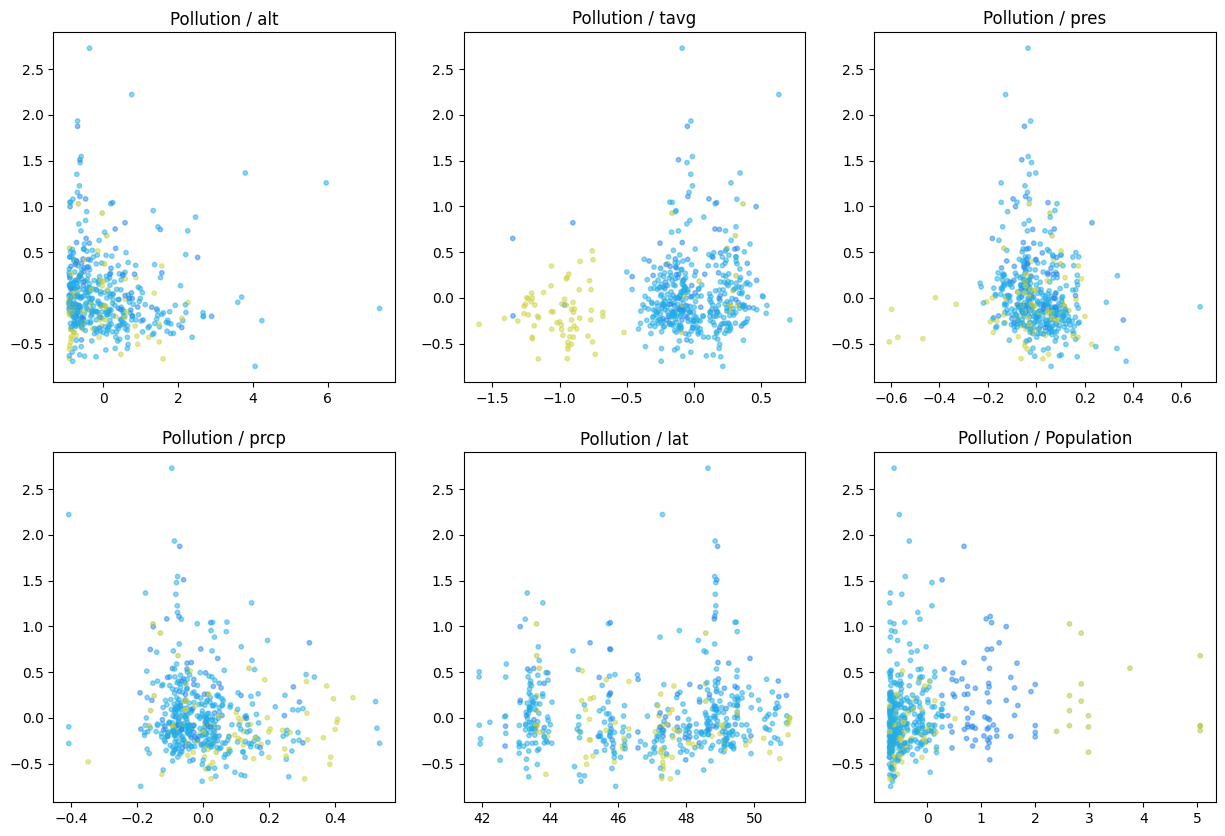

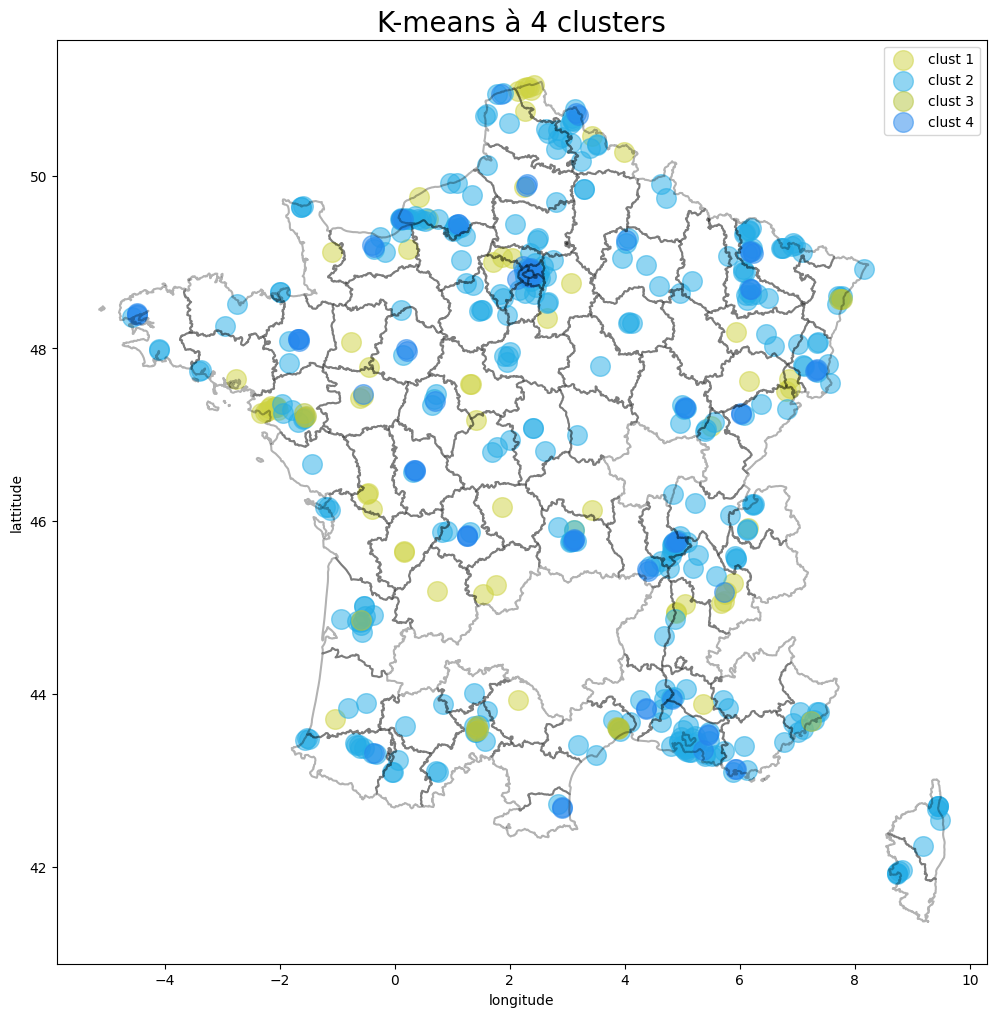

In [16]:

dfk = km(df_mean, 4)

graph_km(dfk, 'cluster')


### PCA sur le dataset pour visualiser les clusters en 2D

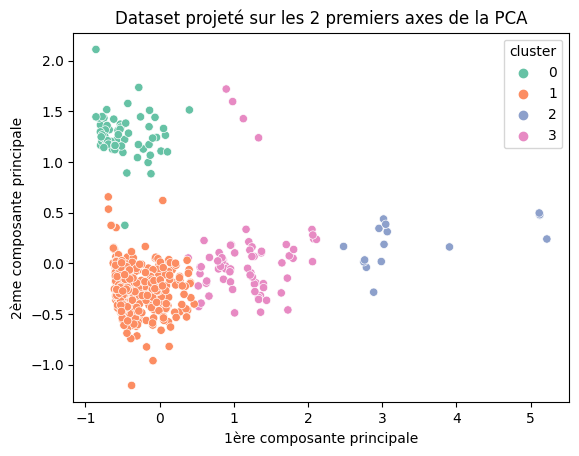

In [17]:
pca_cols = ['mesure', 'PicJourConsoNat',
            'Population', 'tavg',  'pres', 'prcp']

pca = PCA(n_components=2)
dfk_pca = pca.fit_transform(dfk[pca_cols])
sns.scatterplot(x=dfk_pca[:, 0], y=dfk_pca[:, 1],
                hue=dfk["cluster"], palette="Set2")
plt.xlabel("1ère composante principale")
plt.ylabel("2ème composante principale")
plt.title("Dataset projeté sur les 2 premiers axes de la PCA")
plt.show()


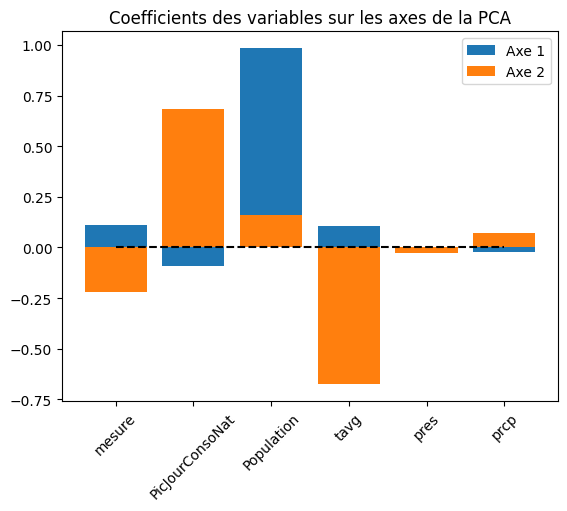

In [18]:
n_feat = pca.n_features_
plt.bar(pca.feature_names_in_, pca.components_[0, :], label="Axe 1")
plt.bar(pca.feature_names_in_, pca.components_[1, :], label="Axe 2")
plt.hlines(0, xmin=0, xmax=n_feat-1, color="black", linestyles="dashed")
plt.xticks(rotation=45)
plt.title("Coefficients des variables sur les axes de la PCA")
plt.legend()
plt.show()


On remarque que le Kmeans effectué ci-dessus n'est pas adapté car la distance sur les métriques de coordonnées prend le pas sur les autres métriques. il faut alors augmenter la valeur de pollution

In [17]:
df_idf = df_mean.loc[df_mean['Code Département'].isin(IDF)]
km(df_idf, 3)


code site Code Département  PicJourConsoNat  Population       alt  \
57    FR04002               92         0.016748   -0.163077 -0.737182   
58    FR04004               75        -0.064302    1.919653 -0.515529   
59    FR04012               75        -0.247006    1.090224 -0.473969   
60    FR04014               94        -0.038107   -0.327916 -0.654062   
61    FR04017               92        -0.064166    0.086798 -0.681769   
62    FR04018               93        -0.097032    0.272569 -0.640209   
63    FR04023               95         1.158627    0.043626 -0.342363   
64    FR04024               95        -0.042822   -0.359314 -0.480896   
65    FR04029               78        -0.069475    0.426943 -0.065296   
66    FR04031               75        -0.018342   -0.177468 -0.695622   
67    FR04034               94        -0.046504   -0.318759 -0.273096   
68    FR04037               75        -0.036572    1.676319 -0.536309   
69    FR04038               78        -0.054757   -0.683760  0.121723   
70    FR04048               95        -0.046803   -0.671986  0.038603   
71    FR04049               91        -0.039096   -0.381555  0.170210   
72    FR04051               95         0.024153    0.640187 -0.543236   
73    FR04055               75        -0.043106   -0.474440 -0.688695   
74    FR04058               93        -0.067175    0.678126 -0.688695   
75    FR04059               93        -0.029228    0.678126 -0.716402   
76    FR04060               75        -0.019229    0.046242 -0.716402   
77    FR04063               78         1.100870   -0.140837 -0.709475   
78    FR04069               77        -0.060884   -0.189242 -0.543236   
79    FR04071               75        -0.046005   -0.474440 -0.709475   
80    FR04098               77        -0.057322   -0.511071 -0.376996   
81    FR04099               94        -0.083610   -0.299135 -0.321583   
82    FR04100               93        -0.052668   -0.338382 -0.342363   
83    FR04101               94         0.006231    0.277802 -0.418556   
84    FR04118               75        -0.014825    0.084182 -0.619429   
85    FR04122               77        -0.058463   -0.189242 -0.598649   
86    FR04123               93        -0.015347    0.272569 -0.626356   
87    FR04131               75        -0.038517    0.084182 -0.640209   
88    FR04135               75         0.000273    1.164794 -0.626356   
89    FR04141               75        -0.031997   -0.335766 -0.688695   
90    FR04142               77        -0.054834   -0.695534  0.190990   
91    FR04143               75        -0.040075   -0.335766 -0.674842   
92    FR04149               91        -0.034011   -0.405103 -0.460116   
93    FR04150               92        -0.117491   -0.117289 -0.529382   
94    FR04156               93        -0.039908   -0.070192 -0.577869   
95    FR04158               95         1.232447   -0.698151 -0.086076   
96    FR04179               92        -0.047209    0.132587 -0.709475   
97    FR04180               91        -0.017253   -0.617039 -0.370069   
98    FR04181               78        -0.045131   -0.363239  0.204843   
99    FR04319               93        -0.079578   -0.622272 -0.480896   
100   FR04323               91         0.037360   -0.019170 -0.370069   
101   FR04324               77         1.193491   -0.687685 -0.099930   
102   FR04328               77         1.241058   -0.695534 -0.051443   
103   FR04329               94        -0.054623   -0.409028 -0.591722   

           lat    lat_cr      long   long_cr      prcp      pres      tavg  \
57   48.929720  0.832167  2.294722  0.832167 -0.077734 -0.036934 -0.117010   
58   48.891666  0.816516  2.346667  0.816516 -0.070948 -0.042939  0.014927   
59   48.827778  0.790239  2.327500  0.790239 -0.109241 -0.095682  0.113539   
60   48.837223  0.794124  2.393900  0.794124 -0.071379 -0.049533 -0.051410   
61   48.881390  0.812289  2.278056  0.812289 -0.082007 -0.049428 -0.066124   
62   48.903900  0.821547  2.384

## Calcul de la distortion

In [19]:
def elb(kmin, kmax):

    elbow_score = []
    for k in range(kmin, kmax+1):
        dfk = df_mean.fillna(0)[['mesure', 'Population',
                                 'alt',
                                 'lat_cr', 'long_cr',
                                 # 'PicJourConsoNat',
                                 #'lat', 'long',
                                 'tavg',  'pres', 'prcp',
                                 ]]
        kmeans_algo = cluster.KMeans(n_clusters=k)
        kmeans_results = kmeans_algo.fit_transform(dfk)
        dfk['label'] = kmeans_algo.labels_
        dist = []
        for i in range(k):
            dist.append(((dfk.groupby('label').get_group(i).drop(
                'label', axis=1)-kmeans_algo.cluster_centers_[i]).apply(abs)**2).sum().sum())

        elbow_score.append(sum(dist))

    plt.figure(figsize=(10, 7))
    plt.plot(np.arange(kmin, kmax+1, 1),  elbow_score)
    plt.title(f'Elbow_score pour k de {kmin} à {kmax}', size=20)
    plt.xlabel('nombre de clusters')
    plt.ylabel('elbow_score')
    plt.grid()
    plt.show()


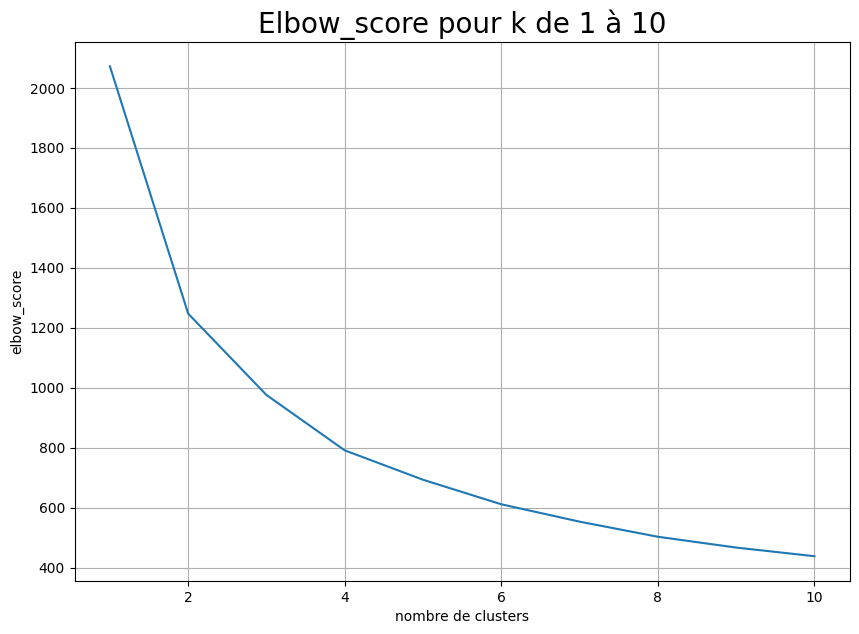

In [19]:
elb(1, 10)


# Classification par arbre avec PCA

In [20]:
# Birch avce PCA

def BC(df, nb_clust=None, nb_comp_pca=3, graph=True):
    dfk = df.fillna(0)
    brc = cluster.Birch(n_clusters=nb_clust)
    dfk_test = dfk[['mesure', 'Population',
                    'alt',
                    'lat_cr', 'long_cr',
                    # 'PicJourConsoNat',
                    #'lat', 'long',
                    'tavg', 'prcp',  'pres'
                    ]]
    pca = PCA(n_components=nb_comp_pca)
    pca.fit(dfk_test)
    df_pca = pca.fit_transform(dfk_test)
    brc.fit(df_pca)
    classification = brc.predict(df_pca)
    dfk['classification'] = pd.DataFrame(classification)
    # if nb_clust == None:
    # colormap = np.array(["#"+''.join([random.choice('ABCDEF0123456789') for i in range(6)]) for _ in range(len(set(classification)))])
    # else:
    # colormap = np.array(["#"+''.join([random.choice('ABCDEF0123456789') for i in range(6)]) for _ in range(nb_clust)])

    colormap = ['red', 'orange', 'yellow', 'green', 'blue', 'black']
    # création d'une liste comportant tous les binômes de paramètres étudiés
    L = ['alt',  'tavg', 'pres', 'prcp', 'lat_cr', 'Population']

    # représentation des six nuages de points pour identifier visuellement le(s) binôme(s) le(s) plus pertinent:
    if graph == True:
        plt.figure(figsize=(15, 10))
        for i in range(len(L)):
            plt.subplot(2, 3, i+1)
            plt.scatter(dfk[L[i]], dfk['mesure'], c=[colormap[j]
                        for j in classification], alpha=0.5, s=10)
            plt.title('Pollution'+' / '+dfk[L[i]].name)
        plt.subplot(2, 3, 6)
        #plt.scatter(dfk['Jx'],dfk['Jy'], c=colormap[classification], alpha = 0.5, s=10)
        # plt.title('Jy/Jx')
        plt.show()

        # Affichage sur la carte
        plt.figure(figsize=(12, 12))

    dep(set(dfk['Code Département']))

    for i in set(classification):
        plt.scatter(dfk.loc[dfk['classification'] == i, 'long'],
                    dfk.loc[dfk['classification'] == i, 'lat'],
                    s=200, alpha=0.5,
                    c=colormap[i],
                    label=f'clust {str(i+1)}')
    plt.title(f'Birch à {nb_clust} clusters avec PCA', size=20)
    plt.xlabel('longitude')
    plt.ylabel('lattitude')
    if graph == True:
        plt.legend()
        plt.show()


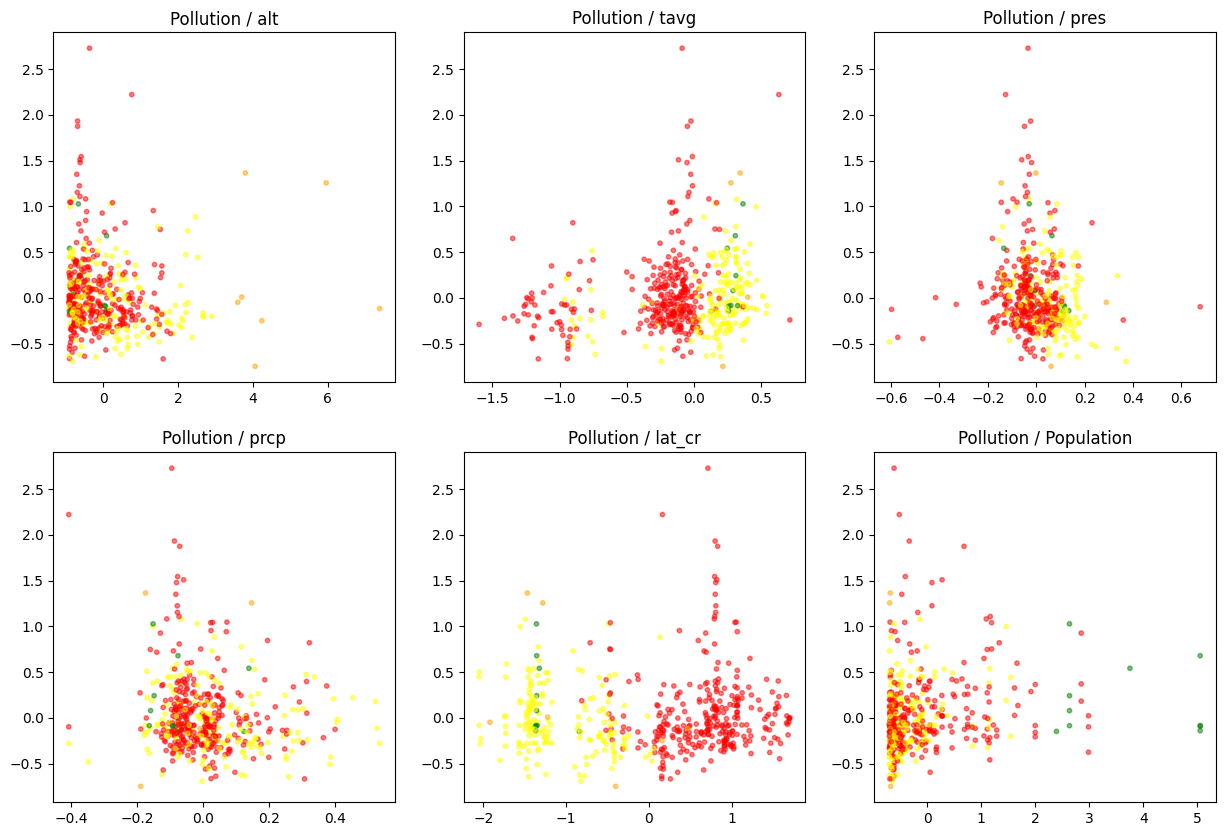

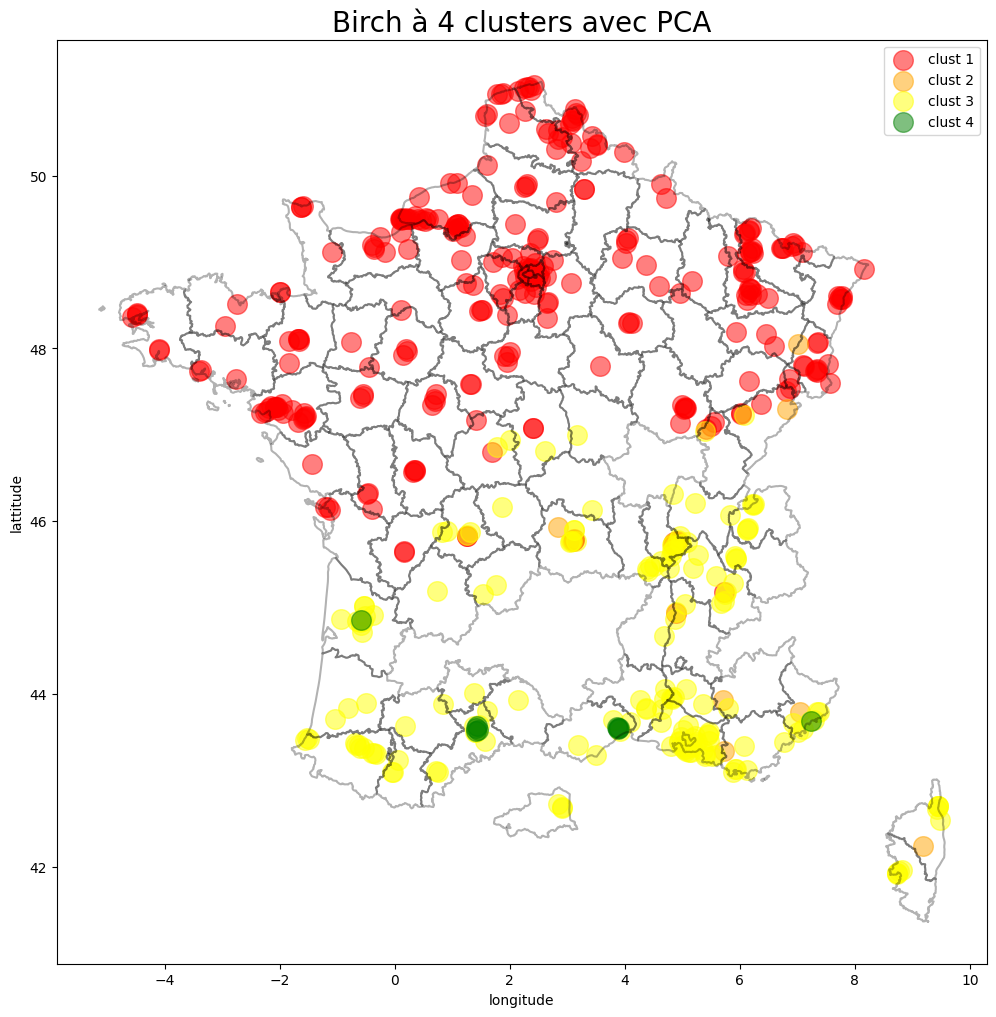

In [21]:
BC(df_mean, nb_clust=4, nb_comp_pca=3)


# DBSCAN

In [22]:
# clustering par dbscan:
def DB(df, epsilon=0.5, ms=5, graph=True):
    dfk = df.fillna(0)
    # .loc[df_mean['GDH'].dt.]
    #dfk = dfk.loc[dfk['mean']<10]

    dbscan_algo = cluster.DBSCAN(eps=epsilon, min_samples=ms)
    dbscan_results = dbscan_algo.fit(dfk[['mesure', 'Population',
                                                    'alt',
                                                    'lat_cr', 'long_cr',
                                                    # 'PicJourConsoNat',
                                                    #'lat', 'long',
                                                    'tavg', 'prcp',  'pres'
                                          ]])

    dfk['classification'] = dbscan_results.labels_
    nb_clust = max(dfk['classification'])
    colormap = np.array(["#"+''.join([random.choice('ABCDEF0123456789')
                        for i in range(6)]) for _ in range(nb_clust+1)])
    # création d'une liste comportant tous les binômes de paramètres étudiés

    if graph == True:
        # Affichage sur la carte
        plt.figure(figsize=(12, 12))

    # on rajoute le dept 11 qui n'a pas de station de mesure si le Df prend en compte toute la France
    if set(dfk['Code Département']) == set(df_tot['Code Département']):
        dep(list(set(dfk['Code Département']))+['11'])
    else:
        dep(set(dfk['Code Département']))

    for i in set(dbscan_results.labels_):
        plt.scatter(dfk.loc[dfk['classification'] == i, 'long'],
                    dfk.loc[dfk['classification'] == i, 'lat'],
                    s=200, alpha=0.5,
                    c=colormap[i],
                    label=f'clust {str(i+1)}')

    plt.xlabel('longitude')
    plt.ylabel('lattitude')
    plt.title(f'dbscan à {nb_clust} clusters', size=20)
    if graph == True:
        plt.legend()
        plt.show()


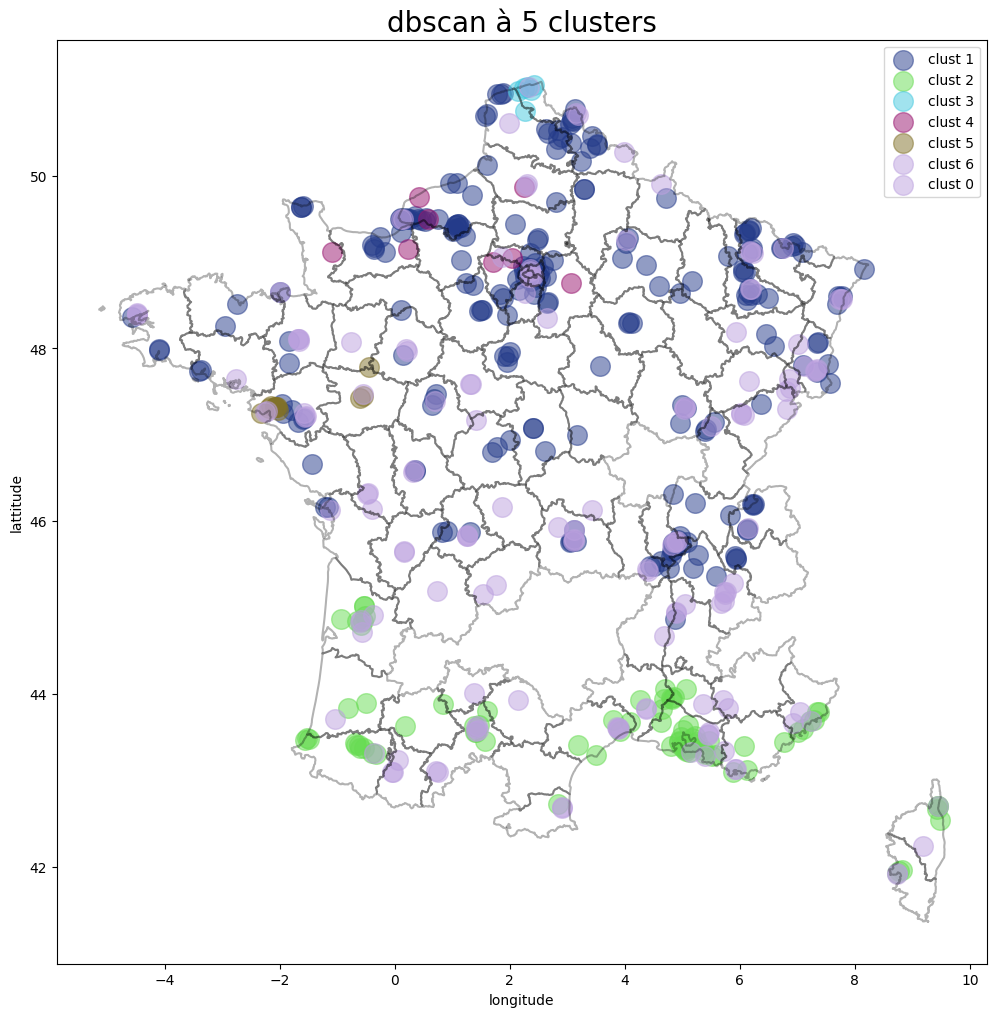

In [23]:
DB(df_mean, epsilon=0.6, ms=6)

In [24]:
# regroupement des trois méthodes de clustering sur la France entière
plt.figure(figsize=(18, 5.5))
plt.suptitle('COMPARAISON DES METHODES DE CLUSTERING')
plt.subplot(131)
km(df_mean, 4, graph=False)
plt.subplot(132)
BC(df_mean, nb_clust=4, nb_comp_pca=3, graph=False)
plt.subplot(133)
DB(df_mean, epsilon=0.6, ms=6, graph=False)
plt.show()


TypeError: km() got an unexpected keyword argument 'graph'

# Prédiction

Il faudrait peut etre utiliser des moyennes mouvantes (rolling mean pour "smoother" les variations...) ?

Essayer PolynomialFeatures n=2 ou 3 avant de passer la LinearRegression

Essayer un SVR ?



In [ ]:
# jeu de test jusqu'au sur deux ans du 17/09/2018 au 16/09/2020
# jeu de validation du 17/09/2020 au 07/03/2021


In [25]:
df_meanpoll = df_tot_std.groupby(['code site', 'GDH']).agg({'PicJourConsoNat': 'first', 'mesure': 'mean',
                                                            # 'lat': 'first', 'long': 'first',
                                                            # 'alt': 'first',
                                                            'Population': 'first',
                                                            'tavg': 'mean', 'prcp': 'mean', 'pres': 'mean',
                                                            'Jx': 'first', 'Jy': 'first'
                                                            })

#df_meanpoll = df_meanpoll.reset_index().drop('code site', axis = 1)
# df_meanpoll.columns
dic = {i: df_meanpoll.loc[i] for i in set(df_tot['code site'])}

PicJourConsoNat    mesure  Population      tavg      prcp  \
GDH                                                                     
2018-09-12              NaN       NaN         NaN       NaN       NaN   
2018-09-17              NaN       NaN         NaN       NaN       NaN   
2018-09-18        -0.591349 -0.397434   -0.635355  1.469841 -0.406339   
2018-09-19        -0.607433 -0.261899   -0.635355  1.485111 -0.406339   
2018-09-20        -0.587779 -0.238517   -0.635355  1.546191 -0.406339   
...                     ...       ...         ...       ...       ...   
2021-03-03         0.563929  0.606453   -0.635355 -0.484735 -0.406339   
2021-03-04         0.485283  0.844551   -0.635355 -0.449105 -0.406339   
2021-03-05         0.500826  0.928915   -0.635355 -0.611986 -0.406339   
2021-03-06         0.427970  0.620106   -0.635355 -0.805408 -0.406339   
2021-03-07         0.354604  0.269502   -0.635355 -0.876668 -0.406339   

                pres        Jx        Jy  
GDH                                       
2018-09-12       NaN       NaN       NaN  
2018-09-17       NaN       NaN       NaN  
2018-09-18  0.226023  0.693980  0.767658  
2018-09-19  0.167232  0.693980  0.767658  
2018-09-20  0.170906 -0.196362  0.974173  
...              ...       ...       ...  
2021-03-03  1.460639  0.693980  0.767658  
2021-03-04  1.229148 -0.196362  0.974173  
2021-03-05  0.949890 -0.910360  0.395531  
2021-03-06  0.799237 -0.910360 -0.532539  
2021-03-07  0.791889 -0.196362 -1.111182  

[889 rows x 8 columns]

In [26]:
def pred(model, site):
    y = dic[site]['mesure']
    y_train, y_test = y[:'16/09/2020'], y['17/09/2020':]
    if len(y_train) > 0 and len(y_test) > 0:
        X = dic[site].drop('mesure', axis=1)
        X_train, X_test = X[:'16/09/2020'], X['17/09/2020':]
        model.fit(X_train, y_train)
        return model.score(X_test, y_test)
    else:
        return 0


<Figure size 1700x1300 with 0 Axes>

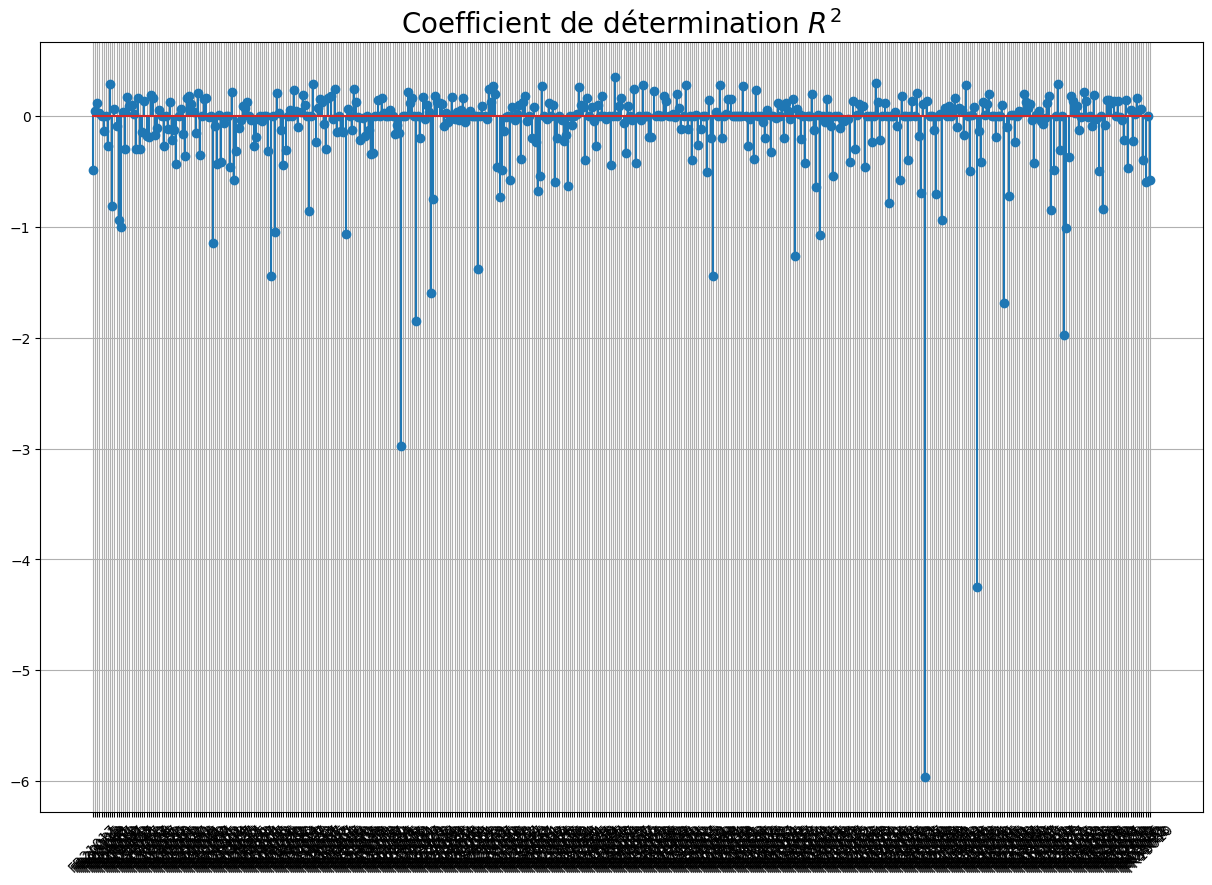

In [47]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

n = 2
#model = make_pipeline(PolynomialFeatures(degree=n), LinearRegression())
model = LinearRegression()
sites = list(set(df_tot['code site']))
scores = [pred(model, i) for i in sites]
plt.figure(figsize=(15, 10))
plt.stem(sites, scores)
plt.title('Coefficient de détermination $R^2$', size=20)
plt.xticks(rotation=45,)
plt.grid()
plt.show()


In [67]:
def train_model(model, site, dic, win_size=3, rolling=True):
    y = dic[site]['mesure']
    y_train, y_test = y[:'16/09/2020'], y['17/09/2020':]
    X = dic[site].drop('mesure', axis=1)
    X_train, X_test = X[:'16/09/2020'], X['17/09/2020':]
    if rolling:
        X_train_roll = X_train.rolling(win_size).mean().iloc[win_size:, :]
        X_train_roll.columns = [f"{x}_roll" for x in X_train_roll.columns]
        X_train = pd.concat([X_train.iloc[win_size:, :], X_train_roll], axis=1)
        y_train = y_train.iloc[win_size:]
        X_test_roll = X_test.rolling(win_size).mean().iloc[win_size:, :]
        X_test_roll.columns = [f"{x}_roll" for x in X_test_roll.columns]
        X_test = pd.concat([X_test.iloc[win_size:, :], X_test_roll], axis=1)
        y_test = y_test.iloc[win_size:]
    model.fit(X_train, y_train)
    data = {'train': X_train, 'y_train': y_train,
            'test': X_test, 'y_test': y_test}
    return data, model


def graph_pred(model, data, site, graph=True, plot_train=False):
    if graph == True:
        plt.figure(figsize=(15, 10))
    if plot_train:
        y_pred0 = pd.DataFrame(model.predict(
            data["train"]), index=data["y_train"].index)[1:]
        plt.plot(y_pred0, label='pred train', alpha=0.5)
        plt.plot(data["y_train"][1:], label='vrai train', alpha=0.5)
    y_pred_test = model.predict(data['test'])
    y_pred1 = pd.DataFrame(y_pred_test, index=data['y_test'].index)
    plt.plot(y_pred1, label='pred test', alpha=0.5)
    plt.plot(data['y_test'], label='vrai test', alpha=0.5)
    commune = df_sites.loc[df_sites['code site'] == site, 'Commune'].values[0]
    score = model.score(data['test'], data['y_test'])
    mse = (1/len(data['y_test'])) * np.sum((y_pred_test - data["y_test"])**2)
    #plt.annotate(f"R2: {score:.2f}", (0.2,0.2))
    plt.title(f"{commune}, R2: {score:.2f}, MSE: {mse:.2f}")
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid()
    if graph == True:
        plt.show()


In [29]:
df_sites['Commune']


0      LONGLAVILLE
1         DISTROFF
2          HAYANGE
3         FLORANGE
4        GANDRANGE
          ...     
828       BESANCON
829        NANCRAY
830        SOCHAUX
831       BESANCON
832       BESANCON
Name: Commune, Length: 833, dtype: object

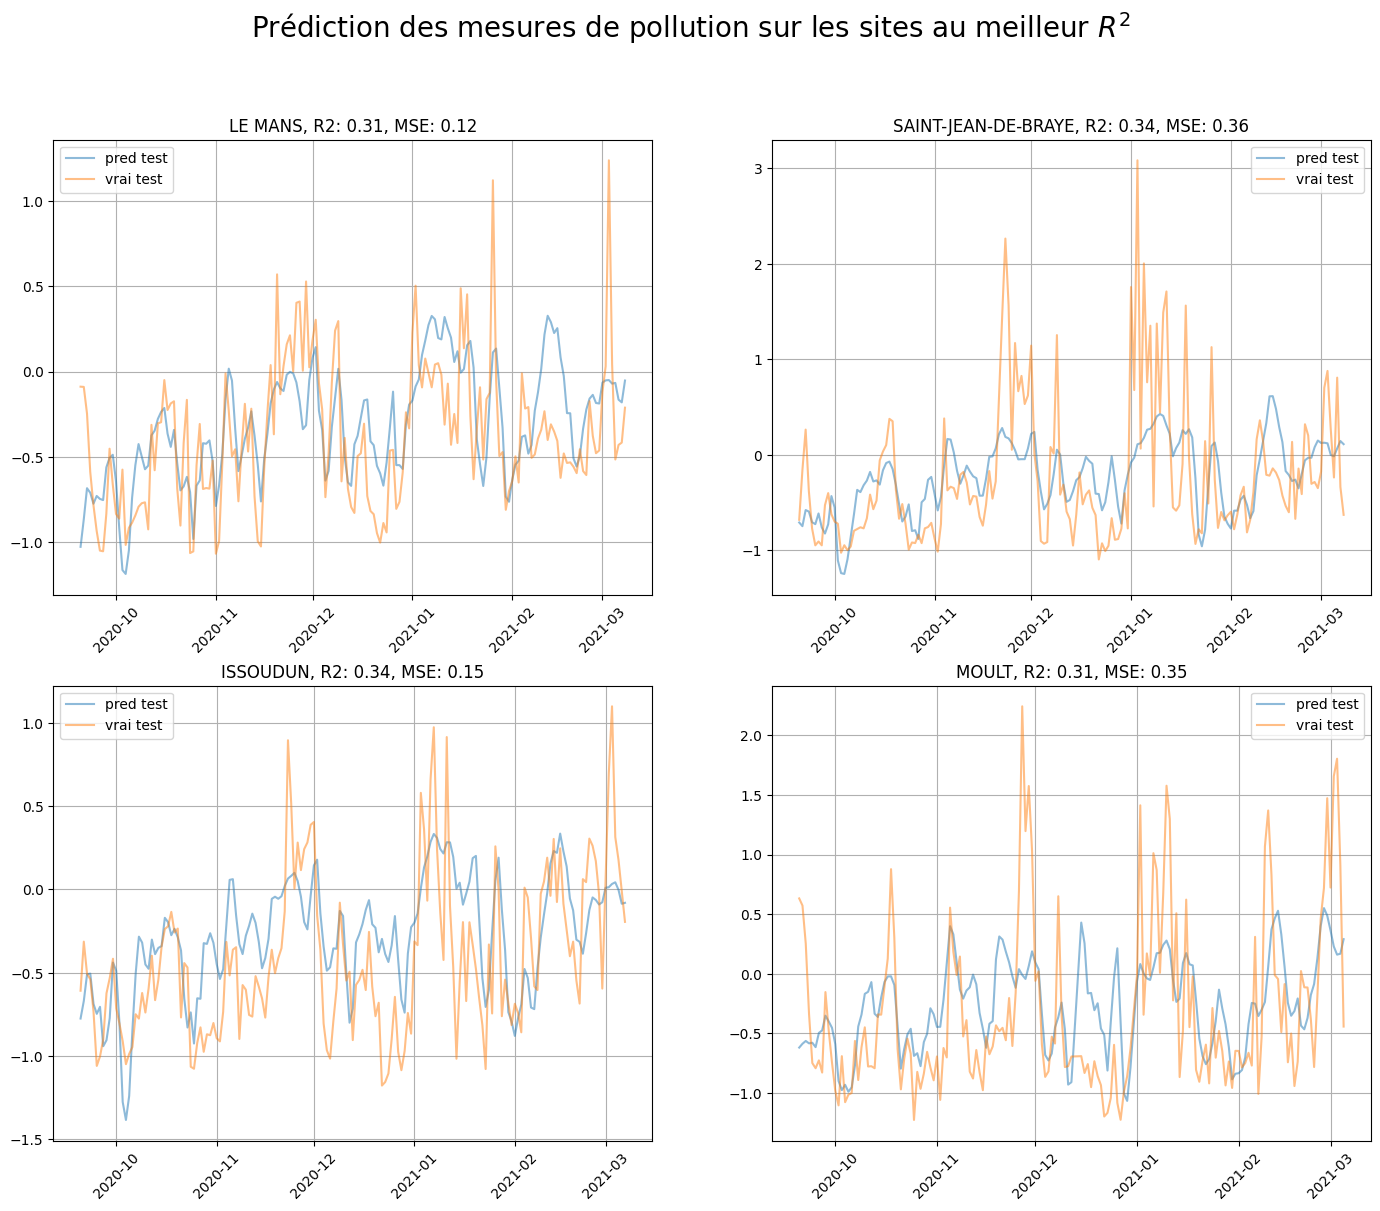

In [71]:
from sklearn.linear_model import Ridge
n = 1
win_size = 3

model = LinearRegression()
#model = Ridge(alpha=1)
#model = make_pipeline(PolynomialFeatures(degree=n), LinearRegression())

top_sites = [sites[scores.index(i)] for i in sorted(scores, reverse=True)[:4]]
plt.figure(figsize=(17, 13))
plt.suptitle(
    'Prédiction des mesures de pollution sur les sites au meilleur $R^2$', size=20
)

for i in range(len(top_sites)):
    data, fitted_model = train_model(
        model, top_sites[i], dic, win_size=win_size, rolling=True)
    plt.subplot(2, 2, i+1)
    graph_pred(fitted_model, data, top_sites[i], graph=False)

plt.show()


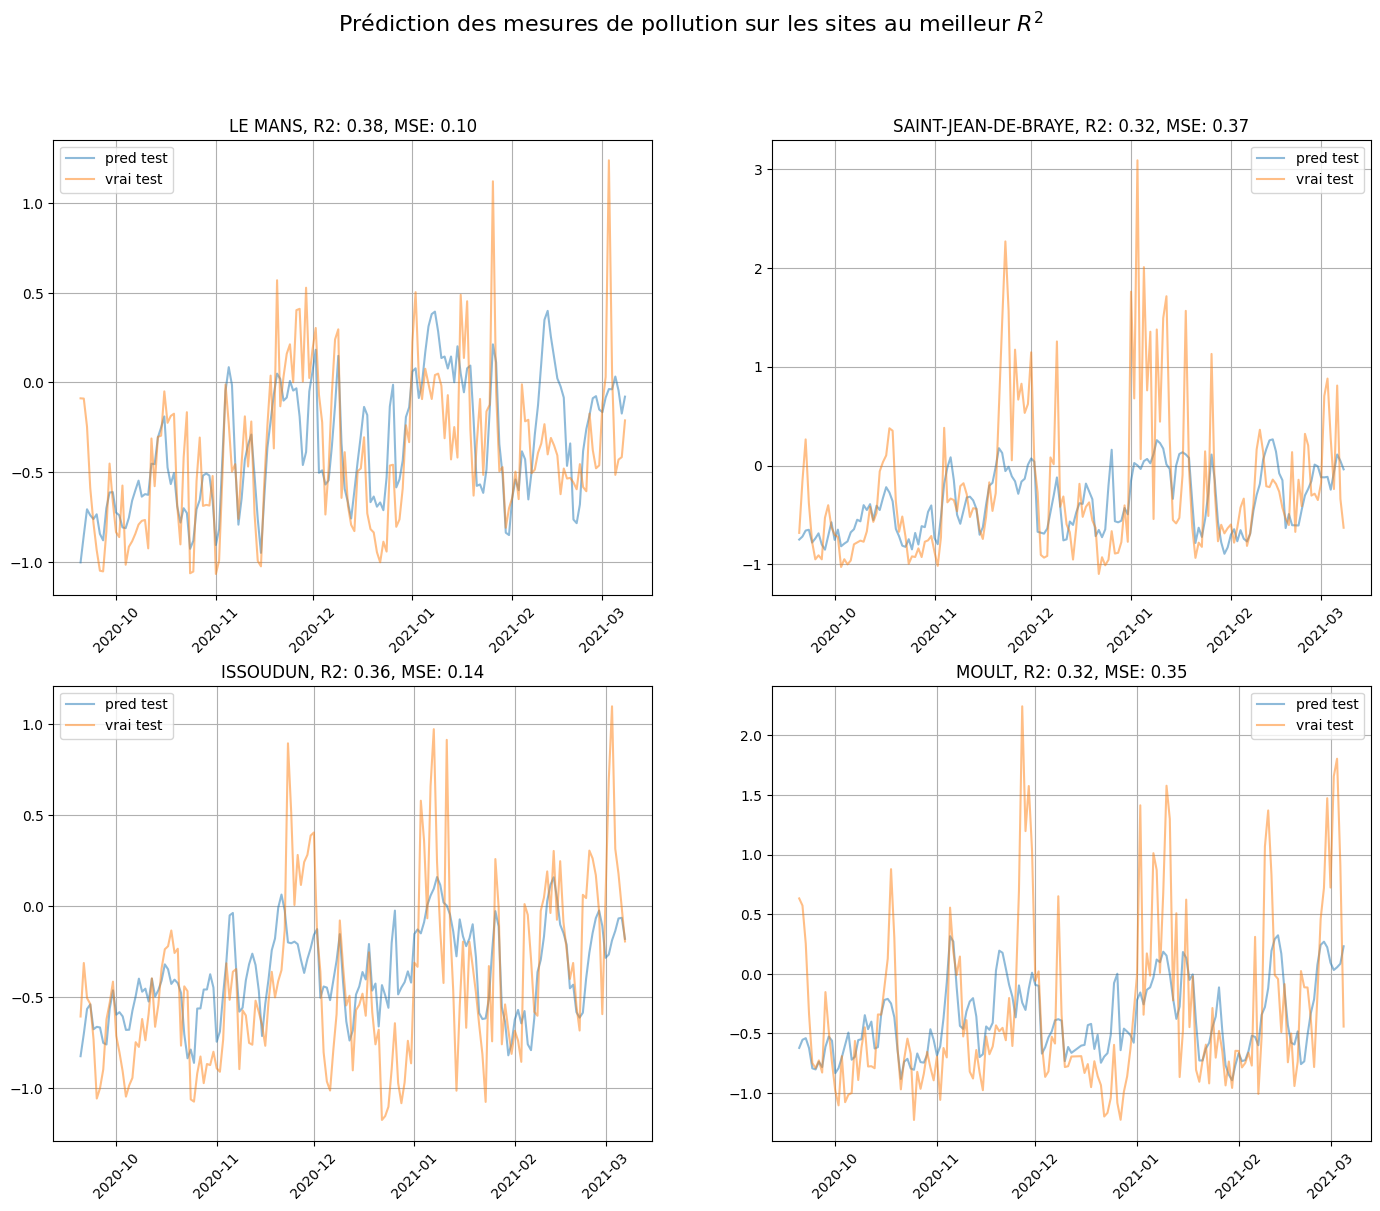

In [79]:
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
win_size = 3


model = make_pipeline(
    #Nystroem(gamma=0.01),
    SVR(kernel="rbf", C=0.1)
)

top_sites = [sites[scores.index(i)] for i in sorted(scores, reverse=True)[:4]]
plt.figure(figsize=(17, 13))
plt.suptitle(
    'Prédiction des mesures de pollution sur les sites au meilleur $R^2$', size=16
)

for i in range(len(top_sites)):
    data, fitted_model = train_model(
        model, top_sites[i], dic, win_size=win_size, rolling=True)
    plt.subplot(len(top_sites)//2, 2, i+1)
    graph_pred(fitted_model, data, top_sites[i], graph=False)

plt.show()


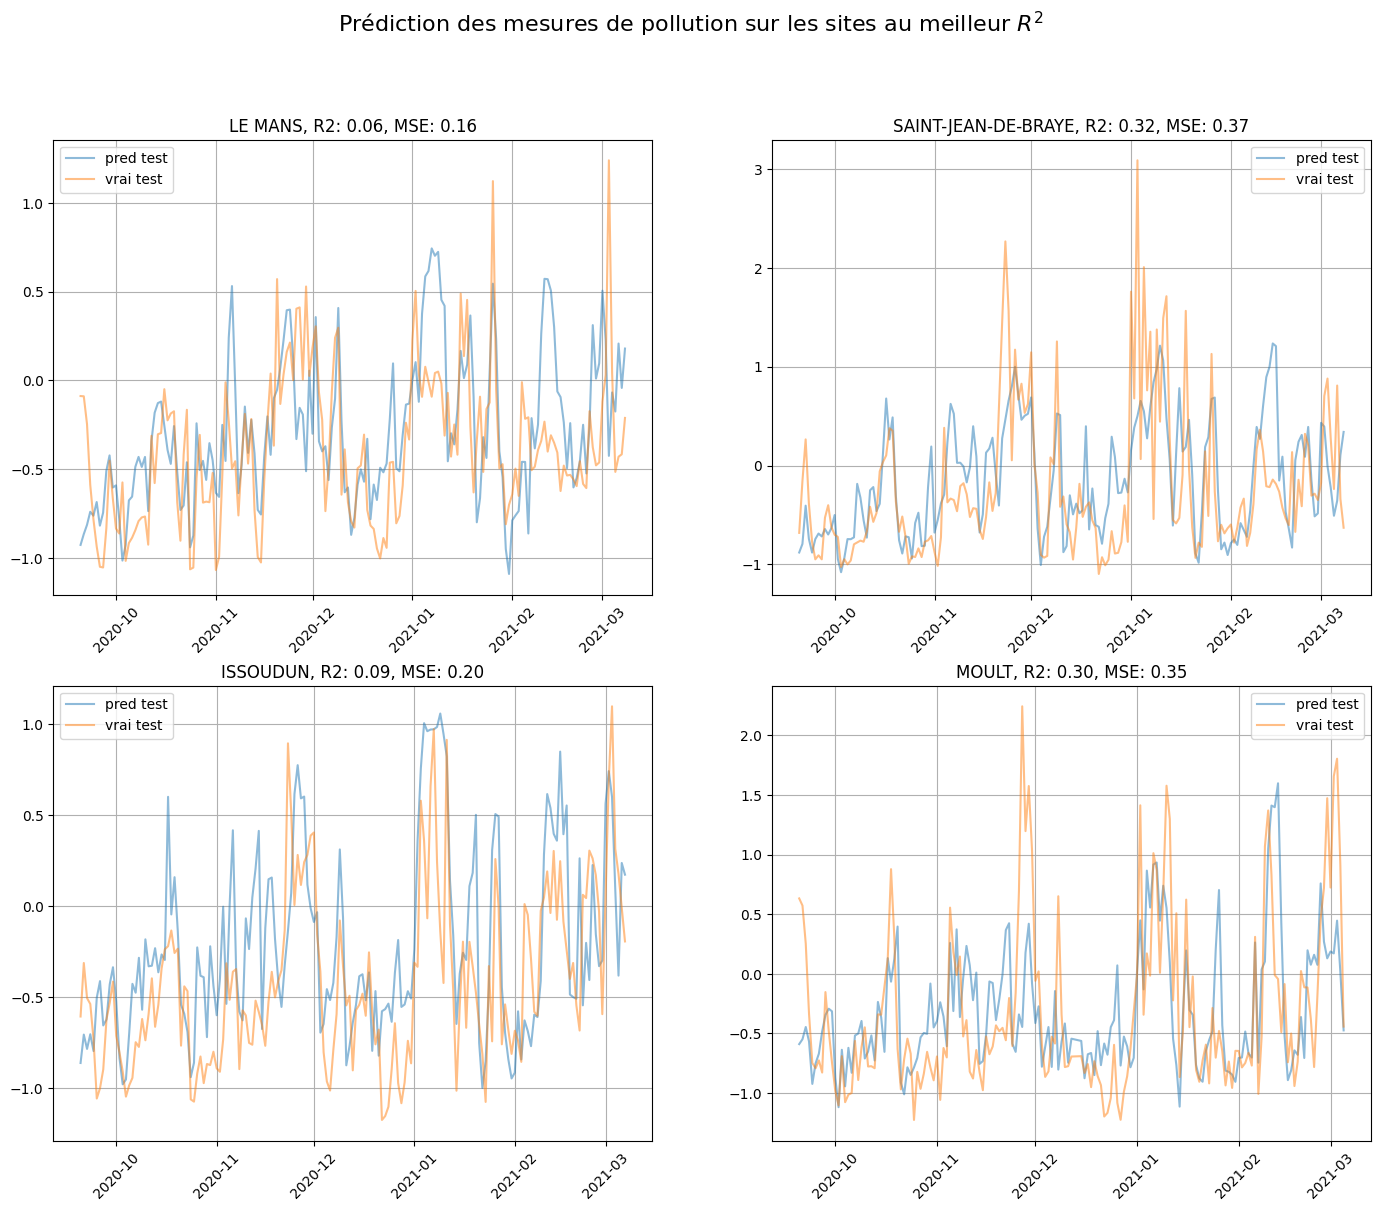

In [72]:
from lightgbm import LGBMRegressor

win_size = 3


model = LGBMRegressor(max_depth=8)

top_sites = [sites[scores.index(i)] for i in sorted(scores, reverse=True)[:4]]
plt.figure(figsize=(17, 13))
plt.suptitle(
    'Prédiction des mesures de pollution sur les sites au meilleur $R^2$', size=16
)

for i in range(len(top_sites)):
    data, fitted_model = train_model(
        model, top_sites[i], dic, win_size=win_size, rolling=True)
    plt.subplot(len(top_sites)//2, 2, i+1)
    graph_pred(fitted_model, data, top_sites[i], graph=False)

plt.show()


In [85]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.fit_transform(X_test)


In [88]:
reg_lass = linear_model.LassoCV(cv=5).fit(X_train, y_train)
reg_lass.score(X_train, y_train)


0.015848503467981834

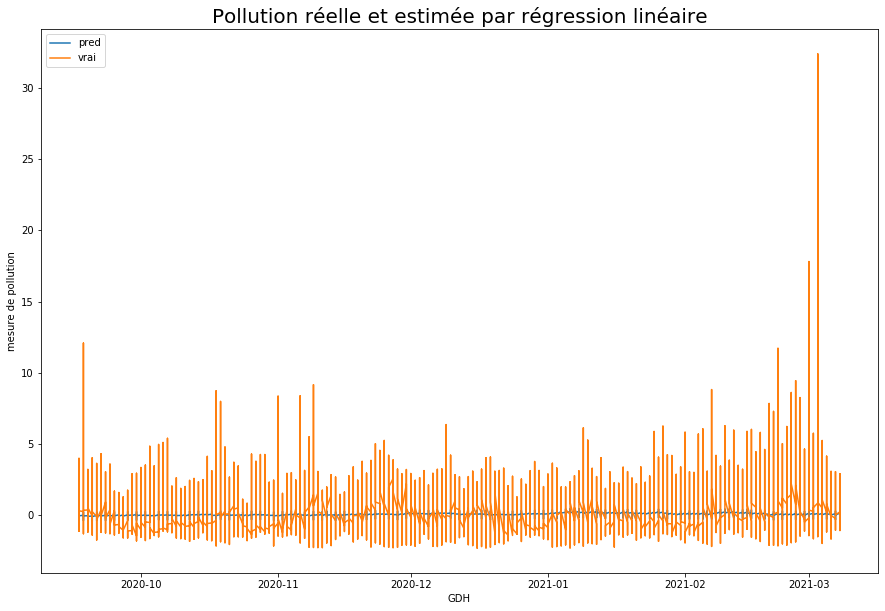

In [89]:
plt.figure(figsize=(15, 10))
plt.plot(pd.DataFrame(reg_lass.predict(X_test),
         index=y_test.index), label='pred')
plt.plot(y_test, label='vrai')
plt.xlabel('GDH')
plt.ylabel('mesure de pollution')
plt.title('Pollution réelle et estimée par régression linéaire', size=20)
plt.legend()
plt.show()


# Etude du confinnement en IDF

In [ ]:
df_tot.set_index('GDH', inplace=True)
df_conf = df_tot.loc['01/2020':'06/2020'].reset_index()
code_IDF = set(
    df_sites.loc[df_sites['Code Département'].isin(IDF), 'code site'])
df_conf = df_conf.loc[df_conf['code site'].isin(code_IDF)]
df_conf = df_conf.groupby(['code site', 'GDH']).agg(
    {'PicJourConsoNat': 'mean', 'mesure': 'mean'}).reset_index()


In [ ]:
plt.figure(figsize=(15, 10))

for site in code_IDF:
    a = df_conf.loc[df_conf['code site'] == site]
    plt.plot(a['GDH'], a['mesure'], alpha=0.3)

df_conf_mean = df_conf.groupby('GDH').agg(
    {'PicJourConsoNat': 'mean', 'mesure': 'mean'})
plt.plot(df_conf_mean.index, df_conf_mean['mesure'], color='red', linewidth=5,
         label='pollution moyenne en IDF')
df_conf_mean['PicJourConsoNat'] = (df_conf_mean['PicJourConsoNat'] -
                                   df_conf_mean['PicJourConsoNat'].mean()) / df_conf_mean['PicJourConsoNat'].std()
plt.plot(df_conf_mean.index, df_conf_mean['PicJourConsoNat'], color='blue', linewidth=5,
         label='consommation nationale')
plt.legend()
plt.grid()
plt.show()
